<a href="https://colab.research.google.com/github/Joshuajee/AI-ML-PROJECTS/blob/master/deeplearning/image classification/Tool Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Remove randomness
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [3]:
# Dataset parameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/train",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
)

Found 251 files belonging to 10 classes.


2025-12-08 17:50:00.862752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-08 17:50:00.872315: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/validation",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
)

Found 83 files belonging to 10 classes.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/test",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
)

Found 86 files belonging to 10 classes.


In [6]:
class_names = train_ds.class_names
class_names

['allen key',
 'chisel',
 'hammer',
 'mallet',
 'plier',
 'saw',
 'scrapper',
 'screw driver flat',
 'screw driver star',
 'spanner']

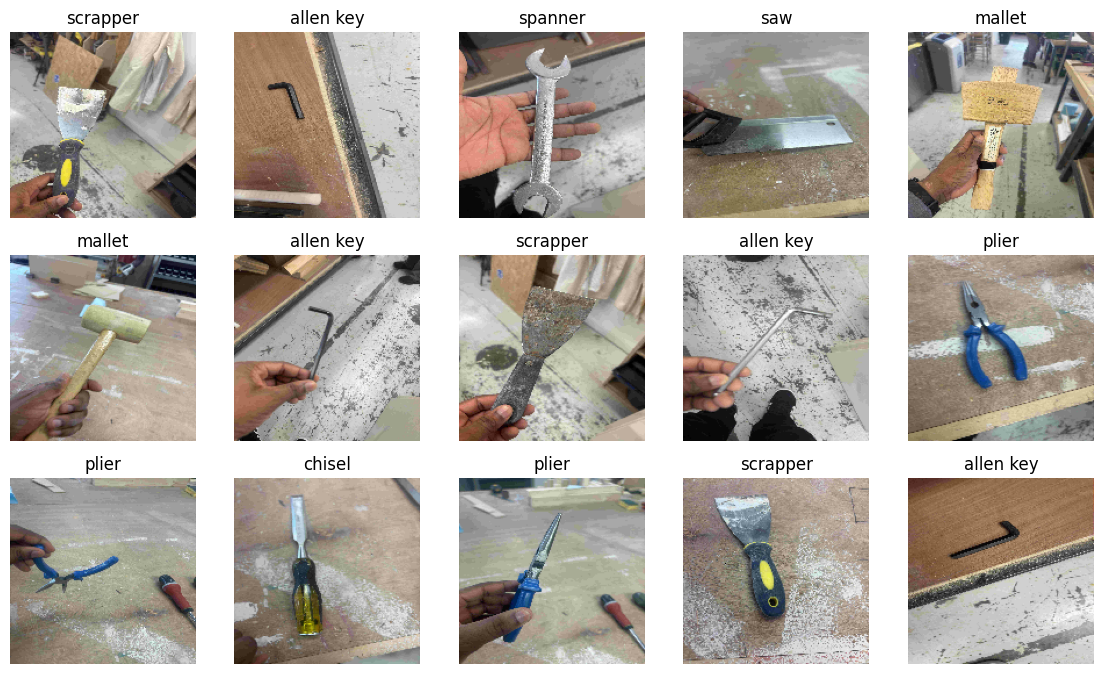

In [7]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 8
Number of validation batches: 3
Number of test batches: 3


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Because I don't have a large image dataset, I'm to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduces overfitting

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.RandomContrast(factor=0.2)
])

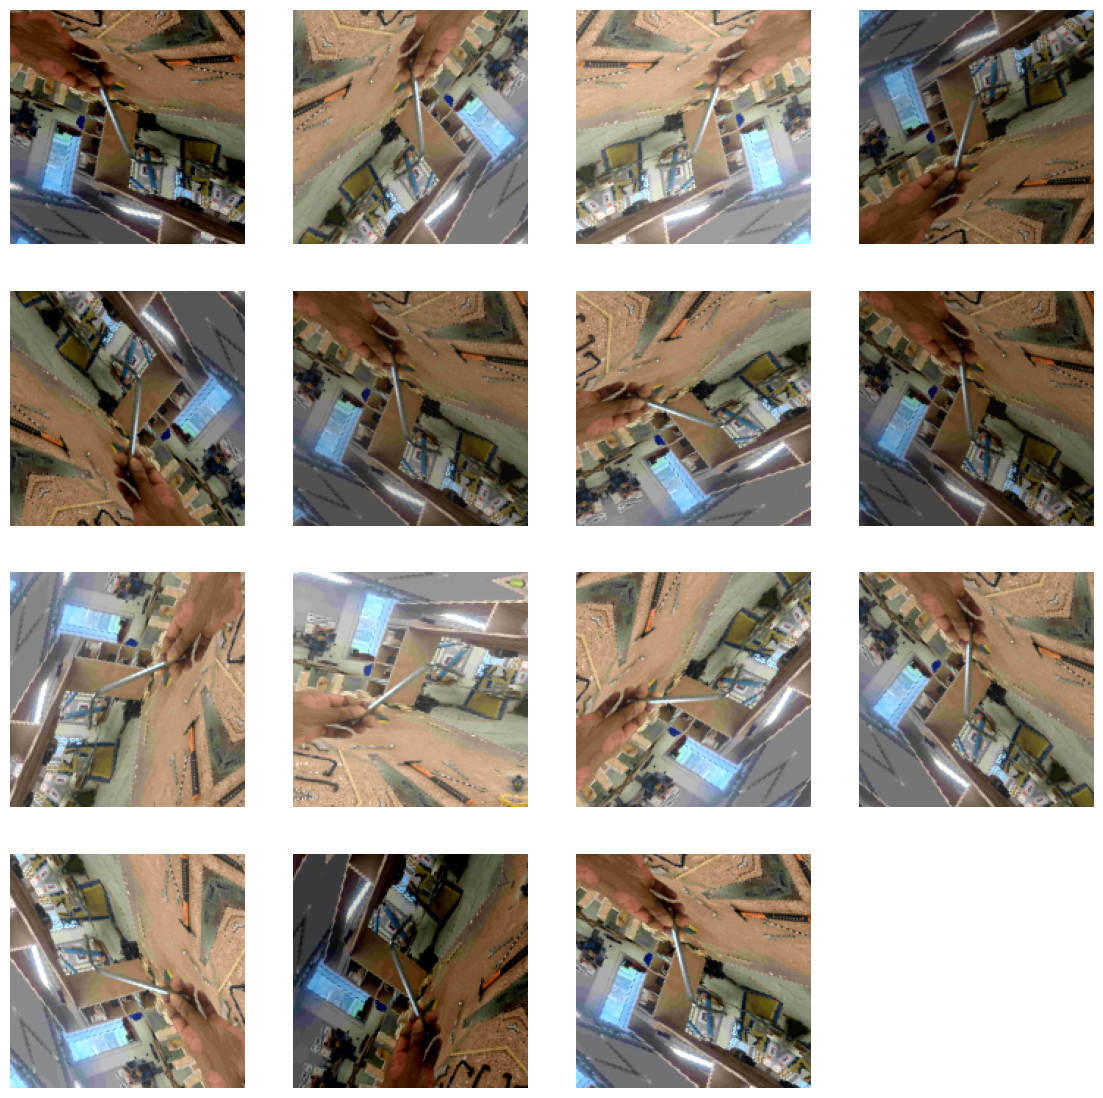

In [11]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(14, 14))
  first_image = image[0]
  for i in range(15):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Building the models



In [12]:
def classifer_model(is_mobilenet, base_learning_rate, fine_tune=False):

    # Create the base model from the pre-trained model MobileNet V2
    IMAGE_SHAPE = IMG_SIZE + (3,)

    if is_mobilenet:
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    image_batch, _ = next(iter(train_ds))
    feature_batch = base_model(image_batch)

    network_depth = len(base_model.layers)

    print("Number of layers in the base model: ", network_depth)

    if fine_tune:
        base_model.trainable = True
        fine_tune_at = int(network_depth * 0.3) # fine tune 30% of the network
        # Freeze all the layers before the `fine_tune_at` layer
        print("Fine Tuning at: ", fine_tune_at)
        for layer in base_model.layers[:fine_tune_at]:
          layer.trainable = False
    else:
        base_model.trainable = False # Freeze all the layers of the model

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)

    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    model.summary()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model



In [49]:
def plot_train_val_stat(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


### Model Test

In [13]:
learning_rate = 0.0001
epochs = 100
mobile_netv2 = classifer_model(True, learning_rate)

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                    

In [14]:
inception_v3 = classifer_model(False, learning_rate)

Number of layers in the base model:  311
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_po

In [15]:
mobile_netv2_finetune = classifer_model(True, learning_rate, True)

Number of layers in the base model:  154
Fine Tuning at:  46
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                        

In [16]:
inception_v3_finetune = classifer_model(False, learning_rate, True)

Number of layers in the base model:  311
Fine Tuning at:  93
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                

In [17]:
history_mobile_netv2 = mobile_netv2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
8/8 [==============================] - 5s 279ms/step - loss: 2.9751 - accuracy: 0.1275 - val_loss: 2.7492 - val_accuracy: 0.0723
Epoch 2/100
8/8 [==============================] - 2s 168ms/step - loss: 2.8261 - accuracy: 0.1076 - val_loss: 2.6454 - val_accuracy: 0.0482
Epoch 3/100
8/8 [==============================] - 2s 163ms/step - loss: 2.7391 - accuracy: 0.1434 - val_loss: 2.5692 - val_accuracy: 0.0723
Epoch 4/100
8/8 [==============================] - 2s 161ms/step - loss: 2.6776 - accuracy: 0.1355 - val_loss: 2.5066 - val_accuracy: 0.0964
Epoch 5/100
8/8 [==============================] - 2s 168ms/step - loss: 2.5718 - accuracy: 0.1793 - val_loss: 2.4487 - val_accuracy: 0.0843
Epoch 6/100
8/8 [==============================] - 2s 161ms/step - loss: 2.4468 - accuracy: 0.1753 - val_loss: 2.3969 - val_accuracy: 0.0964
Epoch 7/100
8/8 [==============================] - 2s 162ms/step - loss: 2.5144 - accuracy: 0.1275 - val_loss: 2.3435 - val_accuracy: 0.0964
Epoch 8/100
8

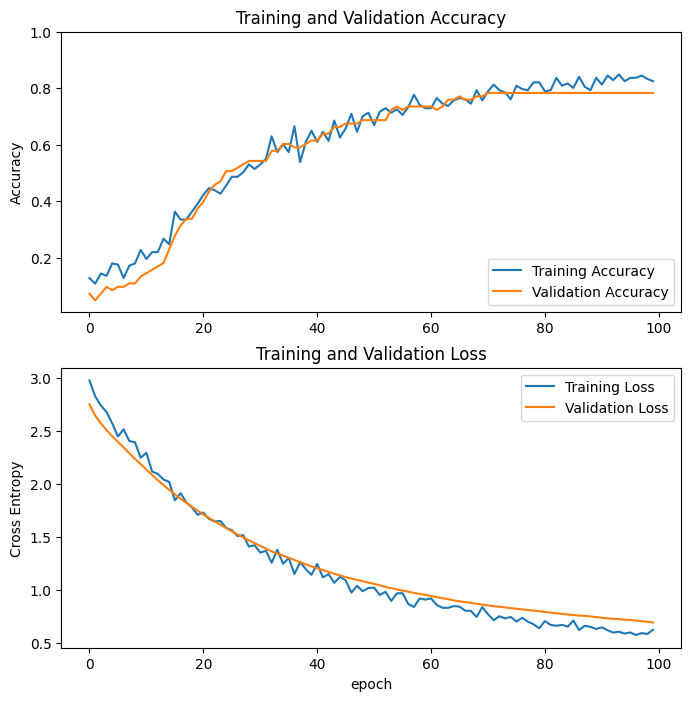

In [50]:
plot_train_val_stat(history_mobile_netv2)

In [18]:
history_inception_v3 = inception_v3.fit(train_ds, epochs=epochs, validation_data=val_ds,)

Epoch 1/100
8/8 [==============================] - 6s 352ms/step - loss: 4.3287 - accuracy: 0.0996 - val_loss: 3.3770 - val_accuracy: 0.0964
Epoch 2/100
8/8 [==============================] - 3s 280ms/step - loss: 3.6363 - accuracy: 0.1076 - val_loss: 3.0350 - val_accuracy: 0.0964
Epoch 3/100
8/8 [==============================] - 3s 279ms/step - loss: 3.2665 - accuracy: 0.1155 - val_loss: 2.9356 - val_accuracy: 0.0964
Epoch 4/100
8/8 [==============================] - 3s 276ms/step - loss: 3.3416 - accuracy: 0.1036 - val_loss: 2.8280 - val_accuracy: 0.0843
Epoch 5/100
8/8 [==============================] - 3s 279ms/step - loss: 3.0913 - accuracy: 0.1912 - val_loss: 2.6983 - val_accuracy: 0.0964
Epoch 6/100
8/8 [==============================] - 3s 276ms/step - loss: 2.8817 - accuracy: 0.2072 - val_loss: 2.5867 - val_accuracy: 0.1325
Epoch 7/100
8/8 [==============================] - 3s 271ms/step - loss: 2.9528 - accuracy: 0.1952 - val_loss: 2.4944 - val_accuracy: 0.1928
Epoch 8/100
8

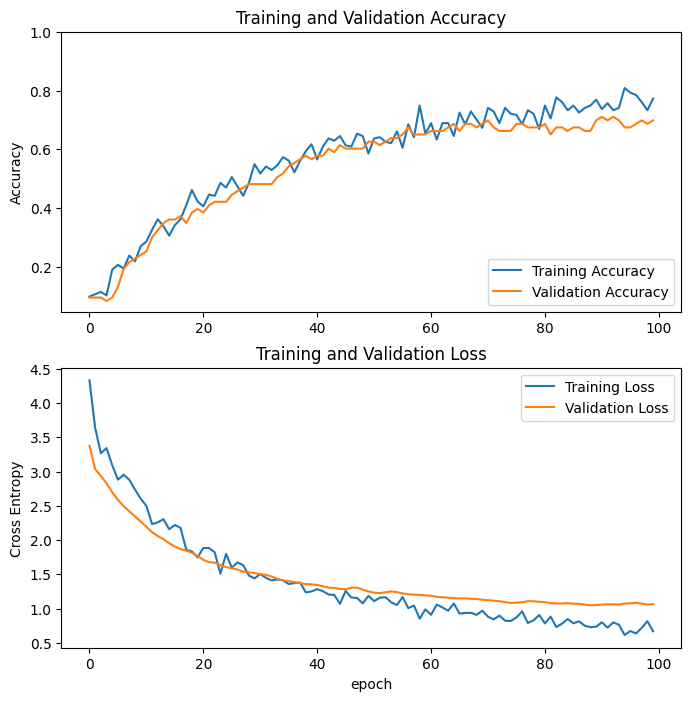

In [21]:
plot_train_val_stat(history_inception_v3)

In [22]:
def make_predictions(model, model_name):

    y_true = []
    y_pred = []
    image_features = []

    model.evaluate(test_ds)

    # Iterate over the test dataset
    for images, labels in test_ds:

        # Get True Labels
        y_true.extend(labels.numpy()) # Use .numpy() to extract data

        # Get Predictions
        predictions = model.predict(images)
        # Convert prediction probabilities to class index (e.g., [0.1, 0.9] -> 1)
        y_pred.extend(np.argmax(predictions, axis=1))

        # Saved the images
        image_features.extend(images)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cr = classification_report(y_true, y_pred, target_names=class_names)

    print(cr)

    # Display the matrix using matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return y_true, y_pred, image_features



In [43]:
def show_images(images, predictions):
    plt.figure(figsize=(15, 15))
    for i in range(15):
       ax = plt.subplot(5, 5, i + 1)
       plt.imshow((images[i] / 255.0))
       plt.title(class_names[predictions[i]])
       plt.axis("off")

1/1 [==============================] - 0s 381ms/step
                   precision    recall  f1-score   support

        allen key       0.86      0.75      0.80         8
           chisel       0.71      0.62      0.67         8
           hammer       0.60      0.38      0.46         8
           mallet       0.82      0.90      0.86        10
            plier       1.00      0.90      0.95        10
              saw       0.91      1.00      0.95        10
         scrapper       0.83      1.00      0.91        10
screw driver flat       0.43      0.43      0.43         7
screw driver star       0.58      1.00      0.74         7
          spanner       1.00      0.62      0.77         8

         accuracy                           0.78        86
        macro avg       0.77      0.76      0.75        86
     weighted avg       0.79      0.78      0.77        86



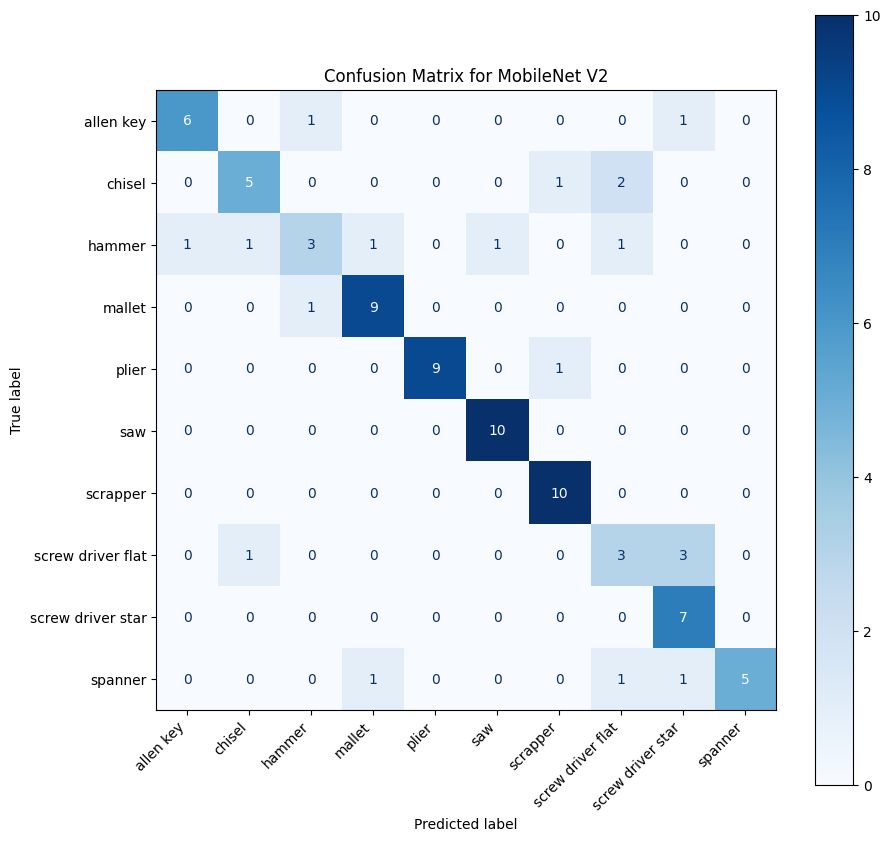

In [24]:
mobile_netv2_pred = make_predictions(mobile_netv2, "MobileNet V2")

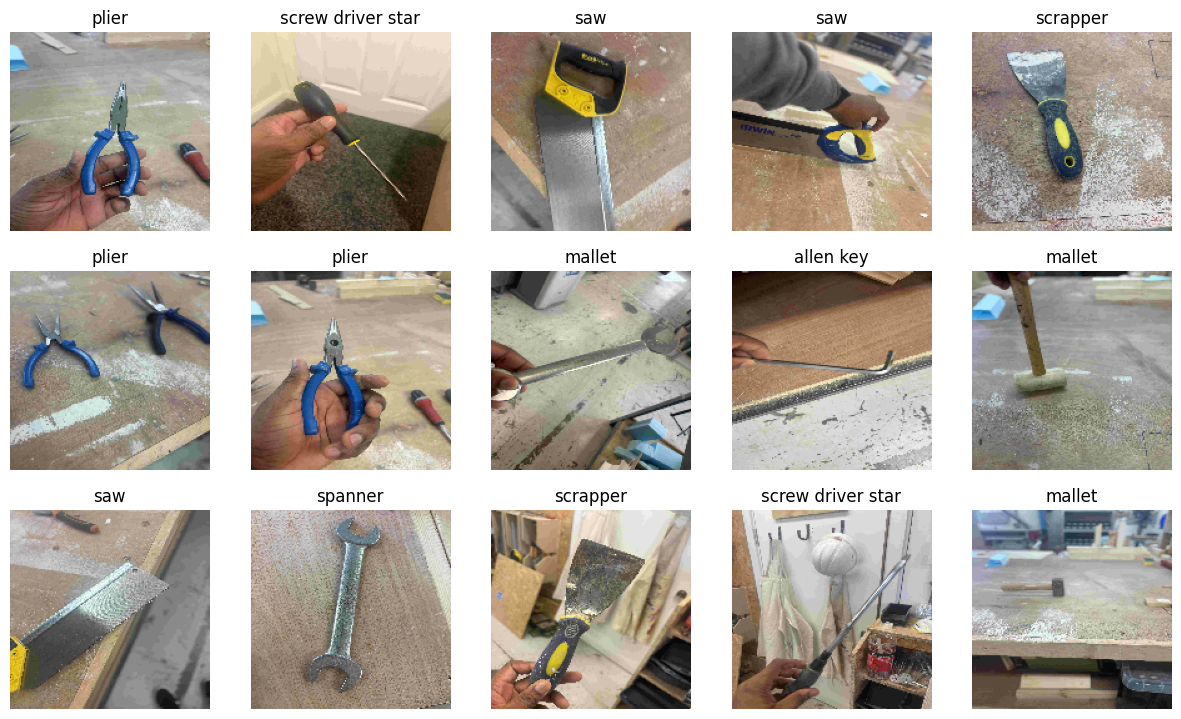

In [44]:
show_images(mobile_netv2_pred[2], mobile_netv2_pred[1])

1/1 [==============================] - 1s 622ms/step
                   precision    recall  f1-score   support

        allen key       0.67      0.75      0.71         8
           chisel       1.00      0.50      0.67         8
           hammer       1.00      0.50      0.67         8
           mallet       0.50      0.80      0.62        10
            plier       0.91      1.00      0.95        10
              saw       1.00      0.80      0.89        10
         scrapper       0.75      0.90      0.82        10
screw driver flat       0.67      0.29      0.40         7
screw driver star       0.67      0.86      0.75         7
          spanner       0.60      0.75      0.67         8

         accuracy                           0.73        86
        macro avg       0.78      0.71      0.71        86
     weighted avg       0.78      0.73      0.73        86



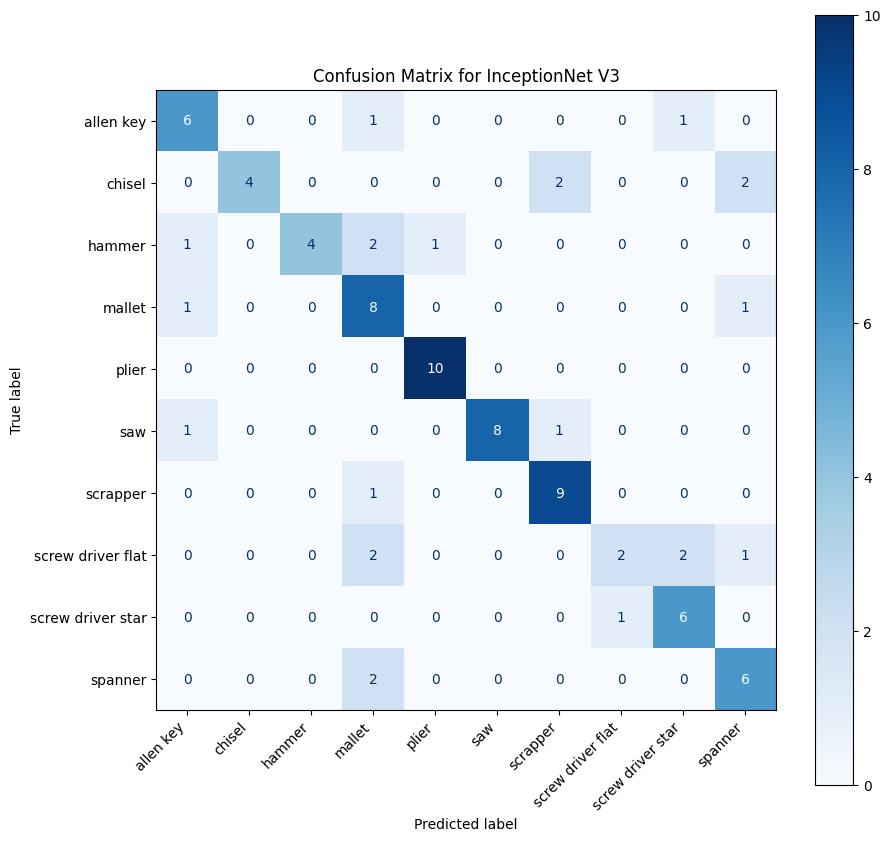

In [26]:
inception_netv3_pred = make_predictions(inception_v3, "InceptionNet V3")

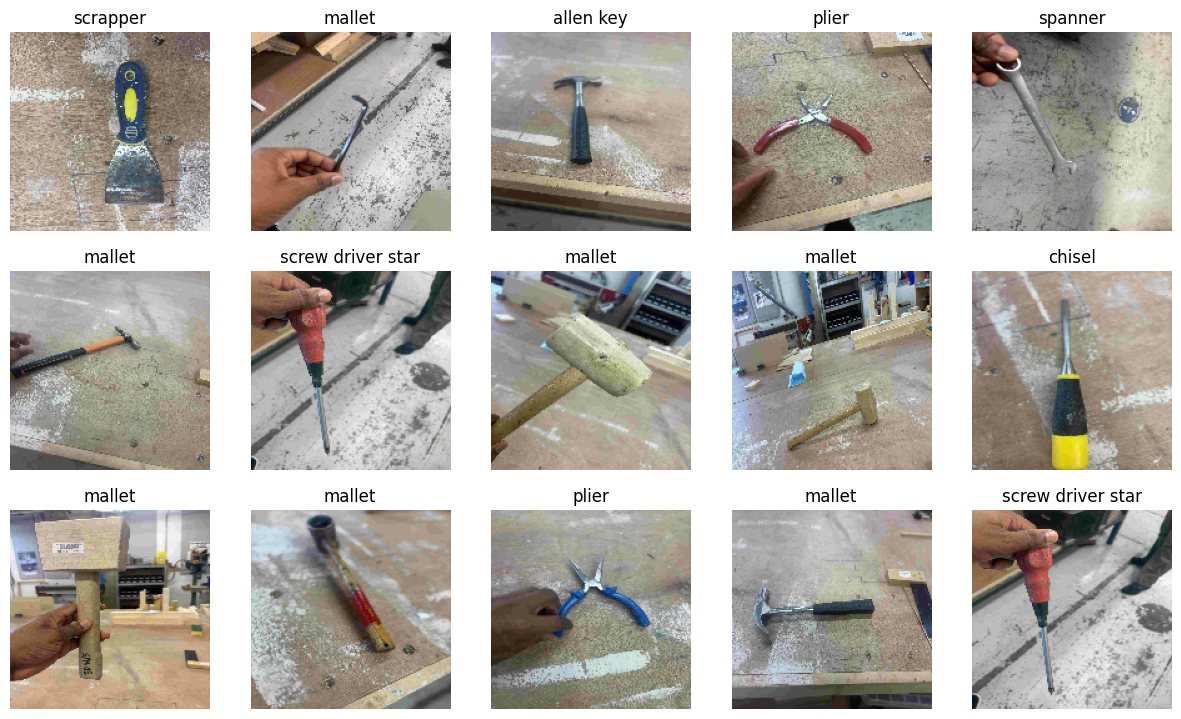

In [45]:
show_images(inception_netv3_pred[2], inception_netv3_pred[1])

In [27]:
history_mobile_netv2_finetune = mobile_netv2_finetune.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
8/8 [==============================] - 7s 308ms/step - loss: 2.3728 - accuracy: 0.1793 - val_loss: 1.9540 - val_accuracy: 0.3614
Epoch 2/100
8/8 [==============================] - 3s 233ms/step - loss: 1.8439 - accuracy: 0.3506 - val_loss: 1.4835 - val_accuracy: 0.4819
Epoch 3/100
8/8 [==============================] - 3s 232ms/step - loss: 1.3764 - accuracy: 0.5896 - val_loss: 1.2033 - val_accuracy: 0.6265
Epoch 4/100
8/8 [==============================] - 3s 234ms/step - loss: 0.9462 - accuracy: 0.7371 - val_loss: 0.9326 - val_accuracy: 0.7108
Epoch 5/100
8/8 [==============================] - 3s 234ms/step - loss: 0.8447 - accuracy: 0.7251 - val_loss: 0.7418 - val_accuracy: 0.7470
Epoch 6/100
8/8 [==============================] - 3s 234ms/step - loss: 0.6794 - accuracy: 0.7809 - val_loss: 0.7961 - val_accuracy: 0.7108
Epoch 7/100
8/8 [==============================] - 3s 235ms/step - loss: 0.5490 - accuracy: 0.8327 - val_loss: 0.6268 - val_accuracy: 0.7711
Epoch 8/100
8

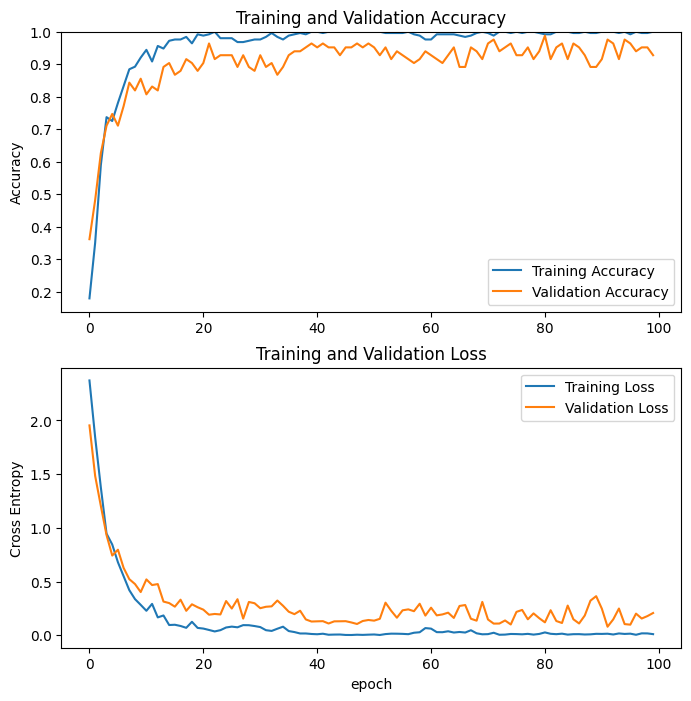

In [48]:
plot_train_val_stat(history_mobile_netv2_finetune)

In [28]:
history_inception_v3_finetune = inception_v3_finetune.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
8/8 [==============================] - 11s 554ms/step - loss: 2.4819 - accuracy: 0.2550 - val_loss: 1.6648 - val_accuracy: 0.4578
Epoch 2/100
8/8 [==============================] - 5s 475ms/step - loss: 1.4366 - accuracy: 0.4940 - val_loss: 1.1207 - val_accuracy: 0.6145
Epoch 3/100
8/8 [==============================] - 5s 478ms/step - loss: 0.9124 - accuracy: 0.7171 - val_loss: 0.9398 - val_accuracy: 0.7229
Epoch 4/100
8/8 [==============================] - 5s 488ms/step - loss: 0.6668 - accuracy: 0.7729 - val_loss: 0.7587 - val_accuracy: 0.7590
Epoch 5/100
8/8 [==============================] - 5s 547ms/step - loss: 0.5508 - accuracy: 0.8207 - val_loss: 0.8230 - val_accuracy: 0.7831
Epoch 6/100
8/8 [==============================] - 5s 507ms/step - loss: 0.3480 - accuracy: 0.8845 - val_loss: 0.7230 - val_accuracy: 0.8072
Epoch 7/100
8/8 [==============================] - 5s 499ms/step - loss: 0.2790 - accuracy: 0.9004 - val_loss: 0.7347 - val_accuracy: 0.7831
Epoch 8/100


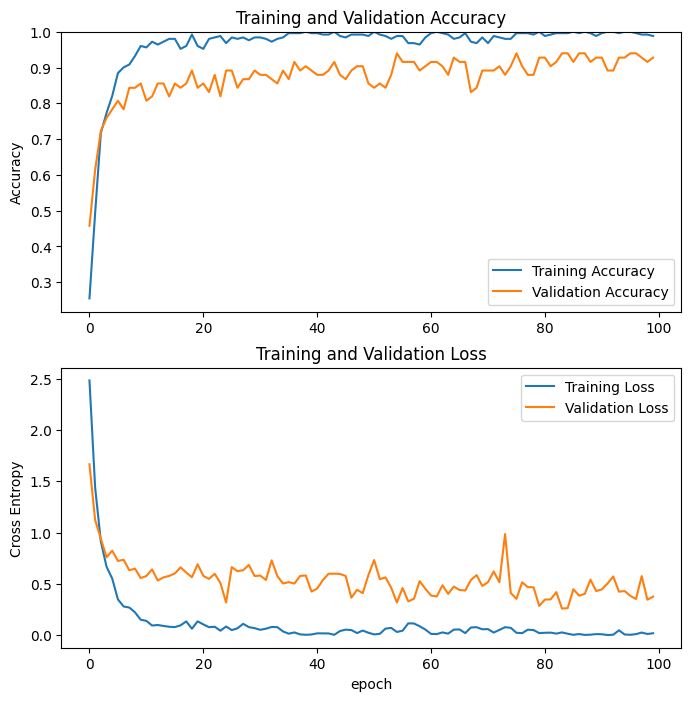

In [30]:
plot_train_val_stat(history_inception_v3_finetune)

1/1 [==============================] - 0s 390ms/step
                   precision    recall  f1-score   support

        allen key       0.89      1.00      0.94         8
           chisel       1.00      1.00      1.00         8
           hammer       1.00      0.62      0.77         8
           mallet       0.91      1.00      0.95        10
            plier       1.00      0.90      0.95        10
              saw       0.83      1.00      0.91        10
         scrapper       0.91      1.00      0.95        10
screw driver flat       1.00      0.86      0.92         7
screw driver star       0.78      1.00      0.88         7
          spanner       1.00      0.75      0.86         8

         accuracy                           0.92        86
        macro avg       0.93      0.91      0.91        86
     weighted avg       0.93      0.92      0.92        86



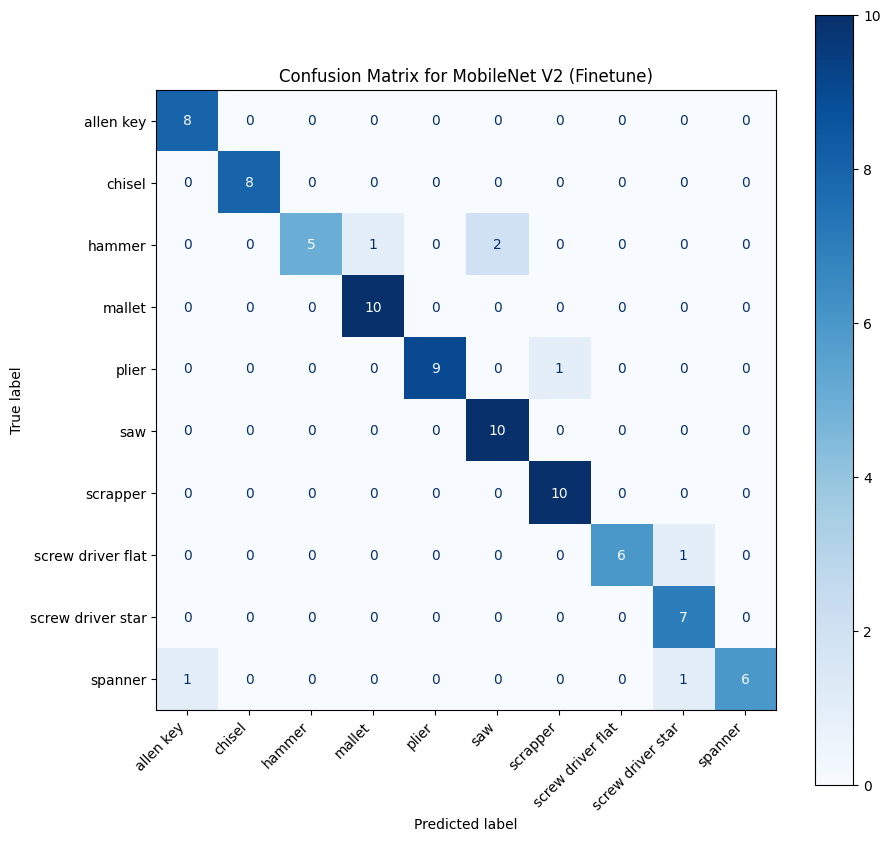

In [31]:
mobile_netv2_finetuned_pred = make_predictions(mobile_netv2_finetune, "MobileNet V2 (Finetune)")

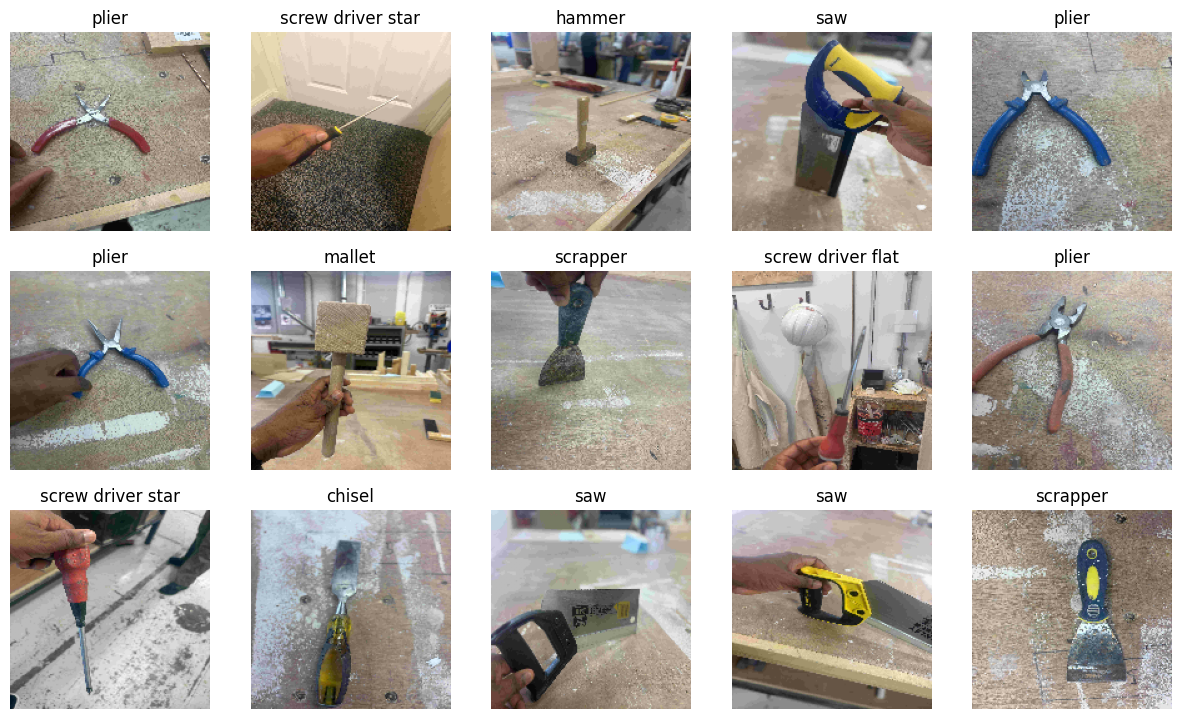

In [46]:
show_images(mobile_netv2_finetuned_pred[2], mobile_netv2_finetuned_pred[1])

1/1 [==============================] - 1s 643ms/step
                   precision    recall  f1-score   support

        allen key       0.73      1.00      0.84         8
           chisel       1.00      1.00      1.00         8
           hammer       1.00      1.00      1.00         8
           mallet       1.00      1.00      1.00        10
            plier       1.00      1.00      1.00        10
              saw       1.00      1.00      1.00        10
         scrapper       0.91      1.00      0.95        10
screw driver flat       0.86      0.86      0.86         7
screw driver star       0.83      0.71      0.77         7
          spanner       1.00      0.62      0.77         8

         accuracy                           0.93        86
        macro avg       0.93      0.92      0.92        86
     weighted avg       0.94      0.93      0.93        86



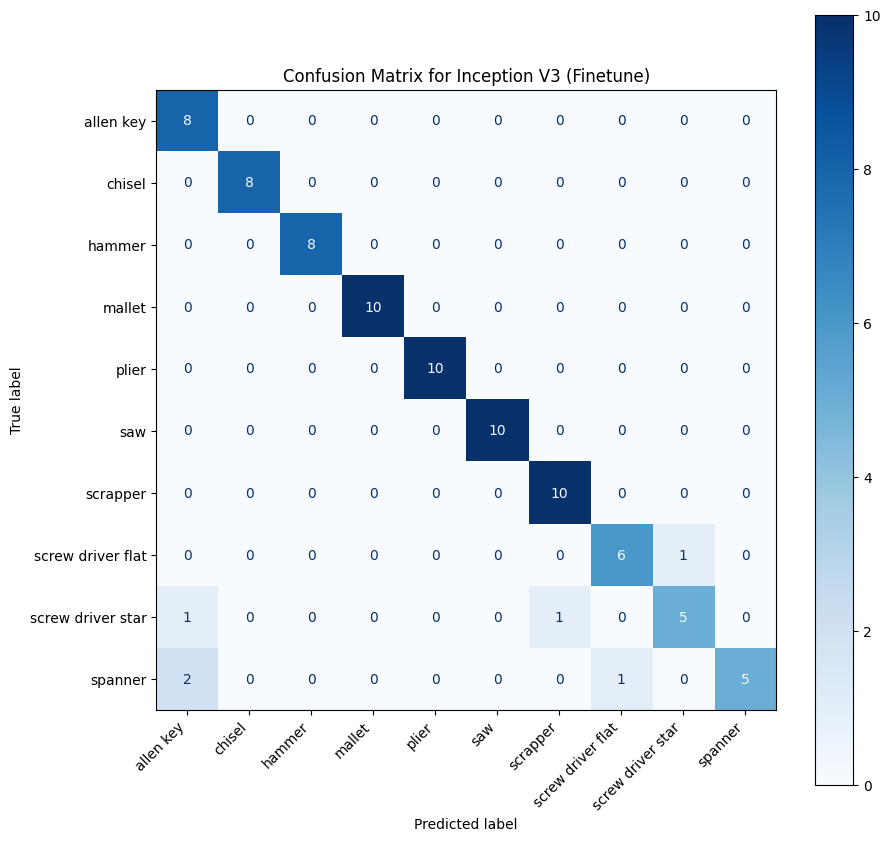

In [32]:
inception_netv3_finetune_pred = make_predictions(inception_v3_finetune, "Inception V3 (Finetune)")

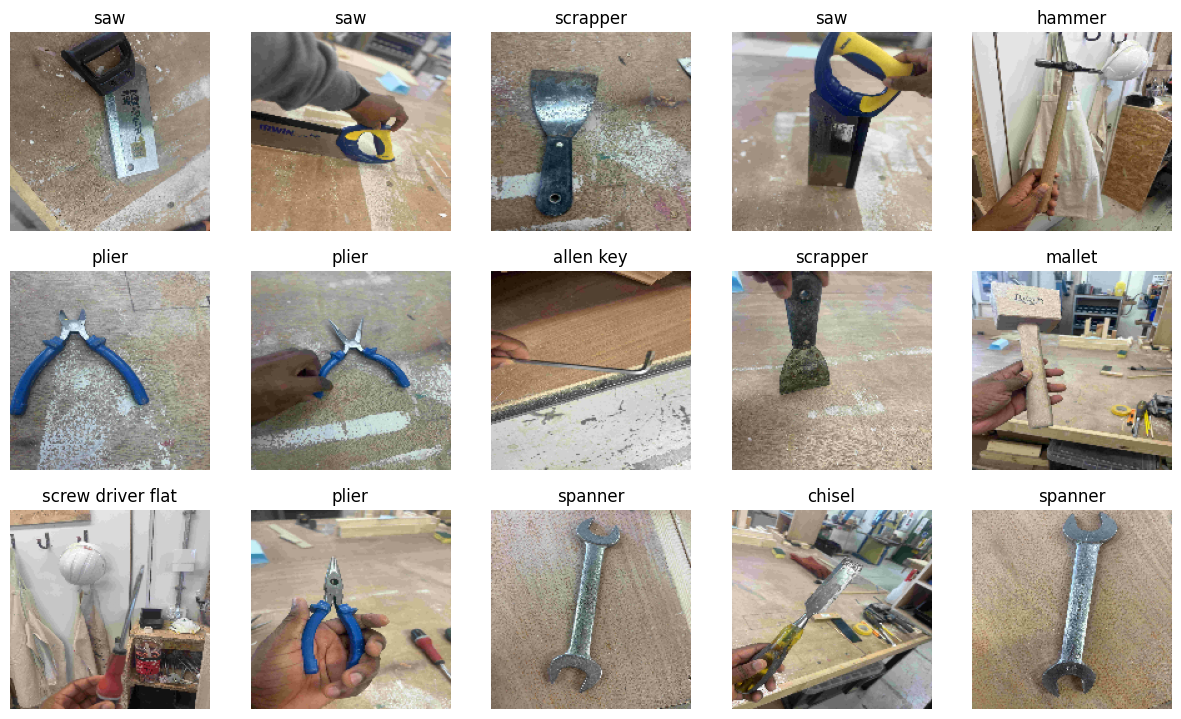

In [47]:
show_images(inception_netv3_finetune_pred[2], inception_netv3_finetune_pred[1])